**Verify NVIDIA GPU Availability**

In [14]:
!nvidia-smi

Wed Apr 16 11:05:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1.&nbsp; Upload through Google Colab



Upload the `data.zip` file to the Google Colab instance by clicking the "Files" icon on the left hand side of the browser, and then the "Upload to session storage" icon. Select the zip folder to upload it.

<p>
<br>
<img src="https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/doc/upload-colab-files.png" height="240">
</p>


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/path/to/data.zip /content

# 2 Split images into train and validation folders

In [15]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

replace /content/custom_data/classes.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/custom_data/notes.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y



I wrote a Python script that will automatically create the required folder structure and randomly move 90% of dataset to the "train" folder and 10% to the "validation" folder. Run the following code block to download and execute the scrpt.

In [16]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-04-16 11:06:17--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-04-16 11:06:18 (51.7 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Number of image files: 15
Number of annotation files: 30
Images moving to train: 13
Images moving to validation: 2


# 3.&nbsp;Install Requirements (Ultralytics)



In [17]:
!pip install ultralytics

# 4.&nbsp;Configure Training


In [18]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 3
names:
- analog_meter
- digital_meter
- gauge


# 5.&nbsp;Train Model with YoloV8s

Run the following code block to begin training. If you want to use a different model, number of epochs, or resolution, change `model`, `epochs`, or `imgsz`.

In [19]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

100% 18.4M/18.4M [00:00<00:00, 262MB/s]
Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

# 6.&nbsp;Test Model

In [20]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.109 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

image 1/4 /content/data/validation/images/51459212-sample_data_1.jpg: 384x640 (no detections), 46.0ms
image 2/4 /content/data/validation/images/70fc7604-sample_data_3.jpg: 384x640 (no detections), 8.9ms
image 3/4 /content/data/validation/images/a6fa2e41-sample_data_5.jpg: 384x640 (no detections), 8.9ms
image 4/4 /content/data/validation/images/f6d66b7f-sample_data_11.jpg: 384x640 (no detections), 12.4ms
Speed: 2.8ms preprocess, 19.0ms inference, 7.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


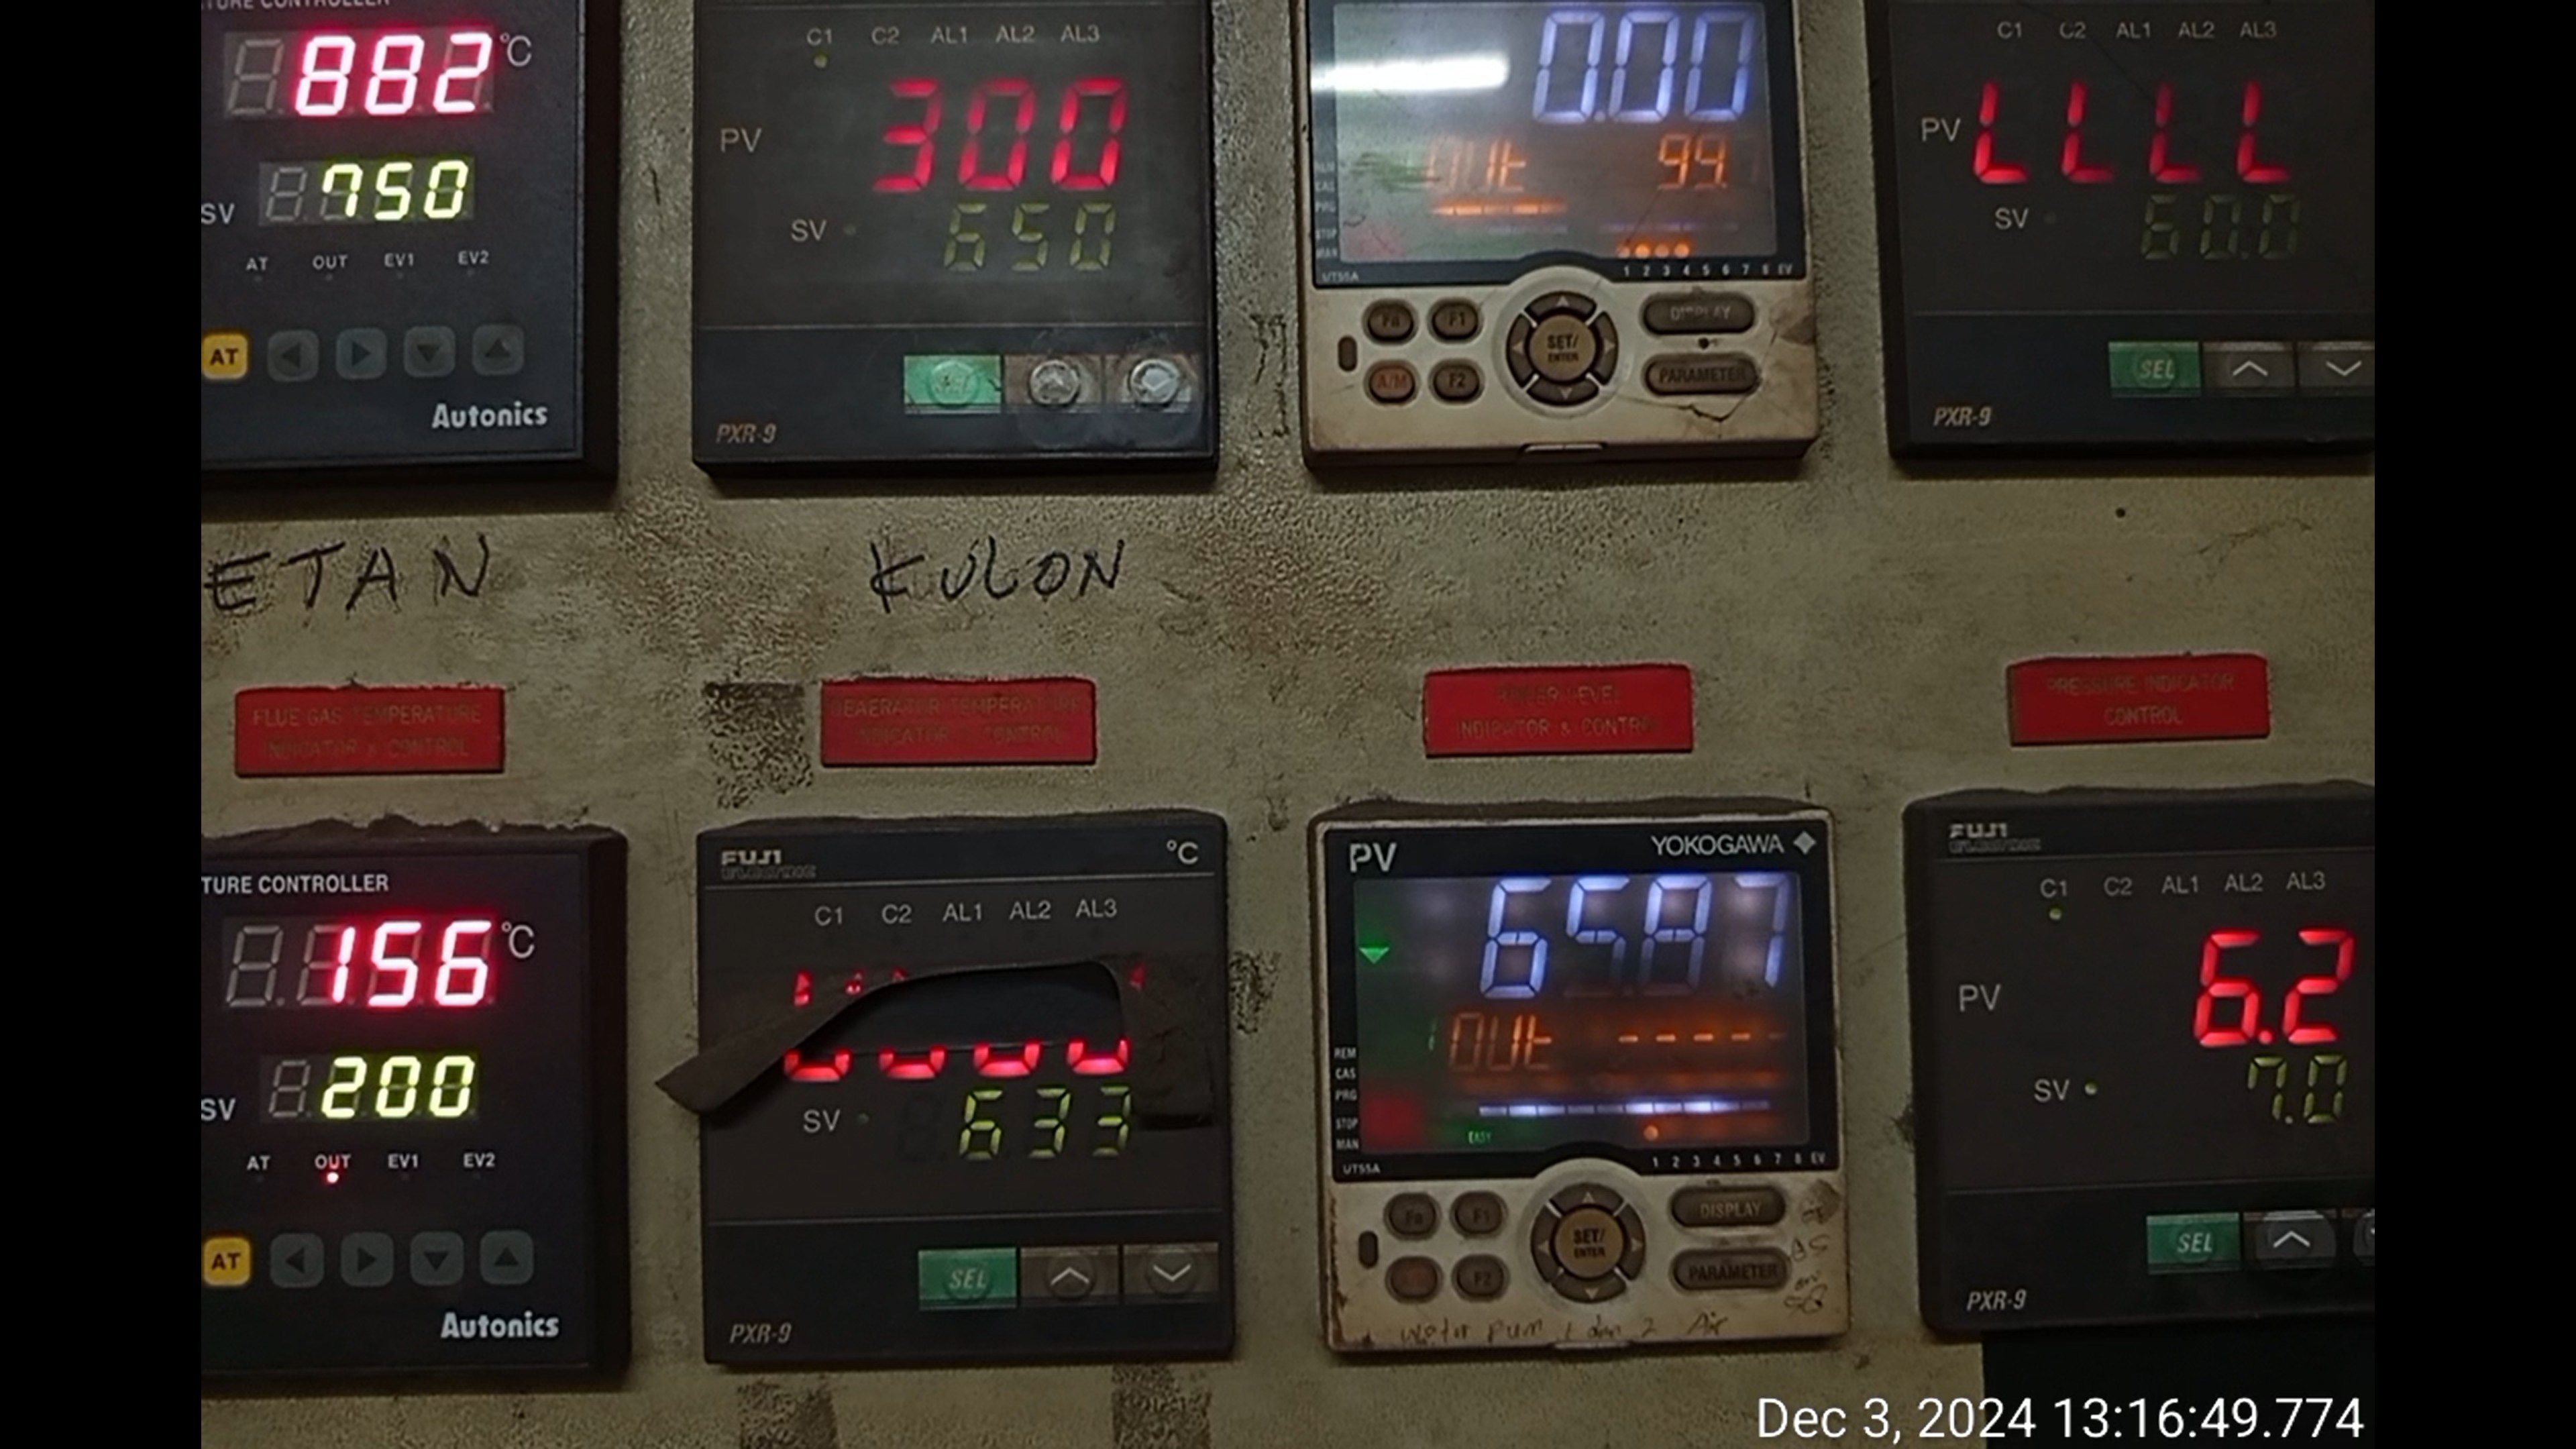

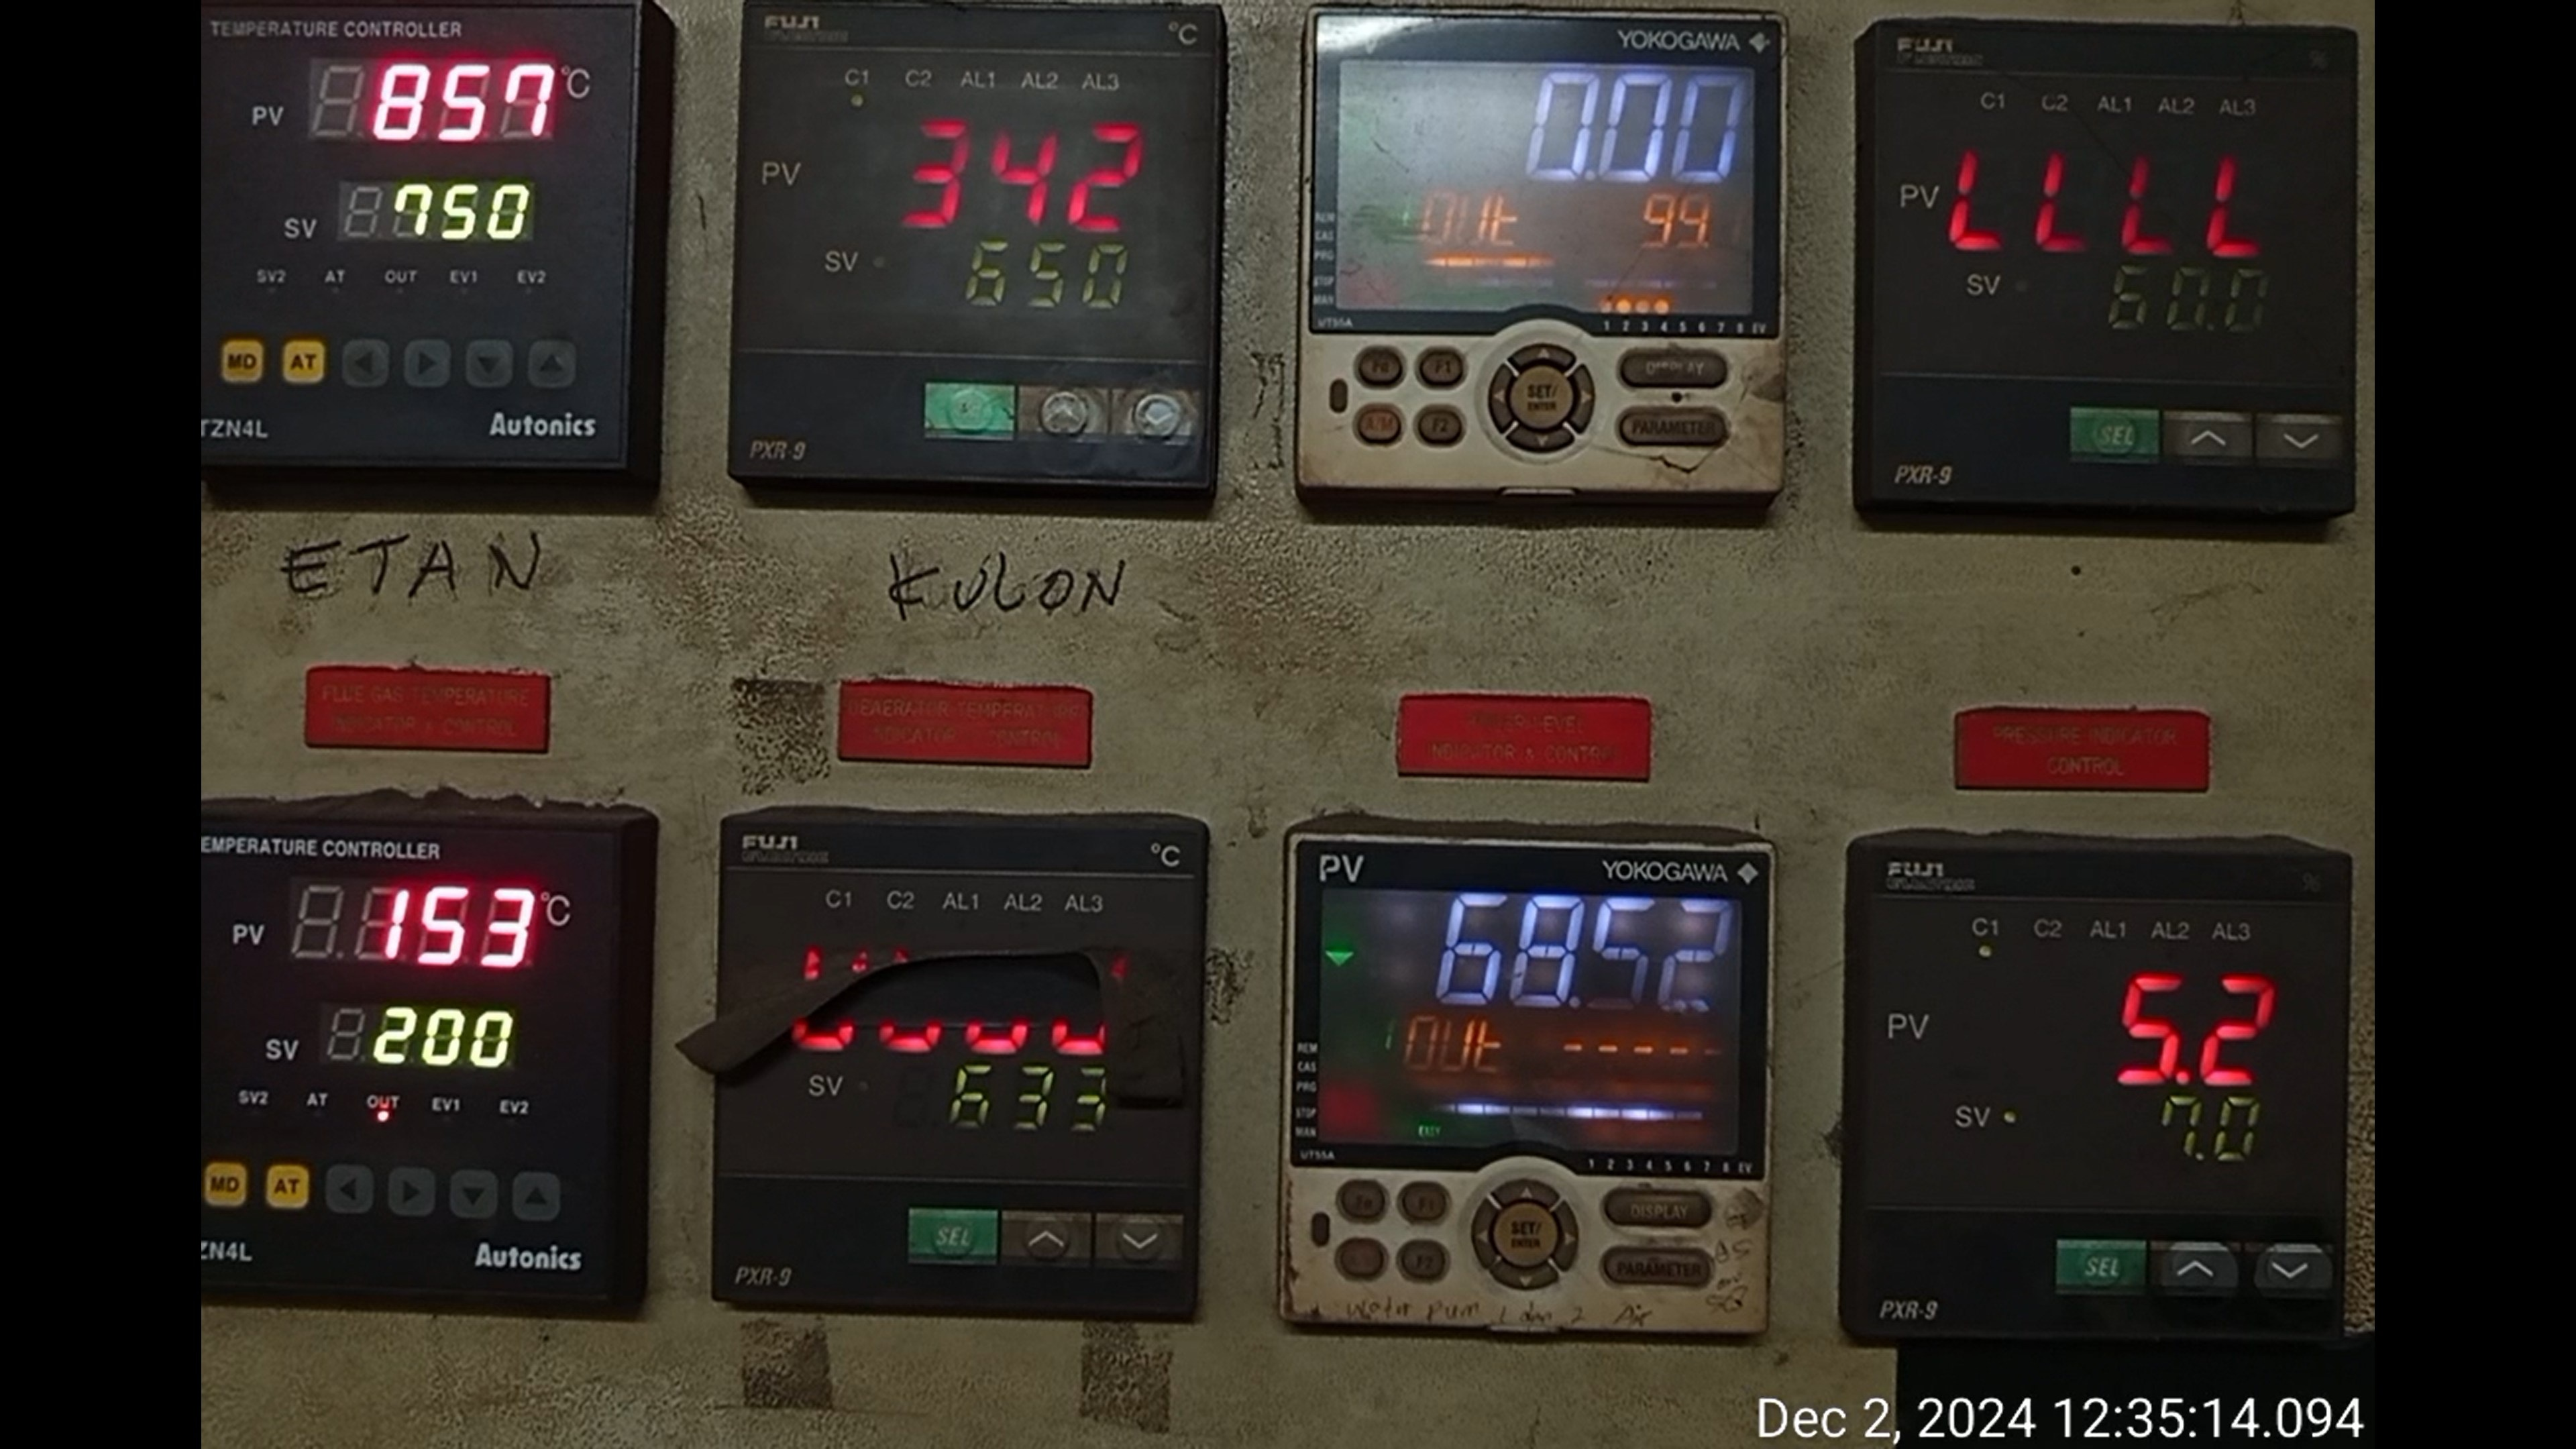

In [21]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


### Infarence form the model

In [22]:
from ultralytics import YOLO

# Load the model
model = YOLO('/content/runs/detect/train2/weights/best.pt')

# Path to your image
image_path = '/content/runs/detect/predict2/51459212-sample_data_1.jpg'  # Replace with the actual path

# Perform object detection
results = model.predict(image_path)

# Print the results (predicted classes and bounding boxes)
print(results)


image 1/1 /content/runs/detect/predict2/51459212-sample_data_1.jpg: 384x640 1 analog_meter, 48.5ms
Speed: 3.5ms preprocess, 48.5ms inference, 151.6ms postprocess per image at shape (1, 3, 384, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'analog_meter', 1: 'digital_meter', 2: 'gauge'}
obb: None
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
